# Imports

In [1]:
import numpy as np
import tensorflow as tf
from neuraxle.api import DeepLearningPipeline
from neuraxle.base import ExecutionContext, DEFAULT_CACHE_FOLDER
from neuraxle.hyperparams.space import HyperparameterSamples
from neuraxle.pipeline import Pipeline, MiniBatchSequentialPipeline
from neuraxle.steps.numpy import OneHotEncoder
from neuraxle.steps.output_handlers import OutputTransformerWrapper
from neuraxle.metaopt.auto_ml import Trainer, ValidationSplitter
from neuraxle.metaopt.callbacks import ScoringCallback
from neuraxle.metaopt.trial import Trial
from neuraxle.steps.flow import TrainOnlyWrapper
from neuraxle.steps.data import DataShuffler
from neuraxle.rest.flask import FlaskRestApiWrapper
from steps.custom_json_decoder_for_2darray import CustomJSONDecoderFor2DArray
from steps.custom_json_encoder_of_outputs import CustomJSONEncoderOfOutputs

from data_reading import load_data
from neuraxle_tensorflow.tensorflow_v1 import TensorflowV1ModelStep
from plotting import plot_metric
from steps.forma_data import FormatData

# Load Data

In [2]:
data_inputs, expected_outputs = load_data()

Some useful info to get an insight on dataset's shape and normalisation:
(data_inputs shape, expected_outputs shape, every data input mean, every data input standard deviation)
(7352, 128, 9) (7352, 1) 0.10206611 0.40216514
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


# Create LSTM RNN Tensorflow Graph

In [3]:
def create_graph(step: TensorflowV1ModelStep):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters.
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network.
    # Note, some code of this notebook is inspired from an slightly different
    # RNN architecture used on another dataset, some of the credits goes to
    # "aymericdamien" under the MIT license.
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)

    # Graph input/output
    data_inputs = tf.placeholder(tf.float32, [None, step.hyperparams['n_steps'], step.hyperparams['n_inputs']],
                                 name='data_inputs')
    expected_outputs = tf.placeholder(tf.float32, [None, step.hyperparams['n_classes']], name='expected_outputs')

    # Graph weights
    weights = {
        'hidden': tf.Variable(
            tf.random_normal([step.hyperparams['n_inputs'], step.hyperparams['n_hidden']])
        ),  # Hidden layer weights
        'out': tf.Variable(
            tf.random_normal([step.hyperparams['n_hidden'], step.hyperparams['n_classes']], mean=1.0)
        )
    }

    biases = {
        'hidden': tf.Variable(
            tf.random_normal([step.hyperparams['n_hidden']])
        ),
        'out': tf.Variable(
            tf.random_normal([step.hyperparams['n_classes']])
        )
    }

    data_inputs = tf.transpose(
        data_inputs,
        [1, 0, 2])  # permute n_steps and batch_size

    # Reshape to prepare input to hidden activation
    data_inputs = tf.reshape(data_inputs, [-1, step.hyperparams['n_inputs']])
    # new shape: (n_steps*batch_size, n_input)

    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(
        tf.matmul(data_inputs, weights['hidden']) + biases['hidden']
    )

    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, step.hyperparams['n_steps'], 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(step.hyperparams['n_hidden'], forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(step.hyperparams['n_hidden'], forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)

    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, weights['out']) + biases['out']

def create_inputs(step: TensorflowV1ModelStep, data_inputs, expected_outputs=None):
    # Add additional inputs to be passed inside the feed dict during sess.run
    if expected_outputs is None:
        # For inference, a default value has to be placed inside the expected outputs placeholder
        return {step['expected_outputs']: np.zeros([data_inputs.shape[0], step.hyperparams['n_classes']])}
    return {}

# Create Optimizer

In [4]:
def create_optimizer(step: TensorflowV1ModelStep):
    return tf.train.AdamOptimizer(learning_rate=step.hyperparams['learning_rate'])

# Create Loss

In [5]:
def create_loss(step: TensorflowV1ModelStep):
    # Loss, optimizer and evaluation
    # L2 loss prevents this overkill neural network to overfit the data
    l2 = step.hyperparams['lambda_loss_amount'] * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

    # Softmax loss
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=step['expected_outputs'],
            logits=step['output']
        )
    ) + l2

# Create Neuraxle Pipeline 

In [6]:
class HumanActivityRecognitionPipeline(MiniBatchSequentialPipeline):
    NAME = 'HumanActivityRecognitionPipeline'
    N_HIDDEN = 32
    N_STEPS = 128
    N_INPUTS = 9
    LAMBDA_LOSS_AMOUNT = 0.0015
    LEARNING_RATE = 0.0025
    N_CLASSES = 6
    BATCH_SIZE = 1500
    EPOCHS = 14

    def __init__(self):
        super().__init__([
            TrainOnlyWrapper(DataShuffler()),
            OutputTransformerWrapper(OneHotEncoder(nb_columns=self.N_CLASSES, name='one_hot_encoded_label')),
            FormatData(n_classes=self.N_CLASSES),
            TensorflowV1ModelStep(
                create_graph=create_graph,
                create_loss=create_loss,
                create_optimizer=create_optimizer,
                create_feed_dict=create_inputs
            ).set_hyperparams(
                HyperparameterSamples({
                    'n_steps': self.N_STEPS,  # 128 timesteps per series
                    'n_inputs': self.N_INPUTS,  # 9 input parameters per timestep
                    'n_hidden': self.N_HIDDEN,  # Hidden layer num of features
                    'n_classes': self.N_CLASSES,  # Total classes (should go up, or should go down)
                    'learning_rate': self.LEARNING_RATE,
                    'lambda_loss_amount': self.LAMBDA_LOSS_AMOUNT,
                    'batch_size': self.BATCH_SIZE
                })
            )
        ], batch_size=self.BATCH_SIZE)
        self.set_name(self.NAME)

# Create scoring metric

In [7]:
def accuracy_score_classification(data_inputs, expected_outputs):
    accuracy = np.mean(np.argmax(data_inputs, axis=1) == np.argmax(expected_outputs, axis=1))
    return accuracy

# Train

In [8]:
trainer = Trainer(
    epochs=HumanActivityRecognitionPipeline.EPOCHS,
    validation_splitter=ValidationSplitter(test_size=0.15),
    scoring_callback=ScoringCallback(metric_function=accuracy_score_classification, higher_score_is_better=True)
)

pipeline: MiniBatchSequentialPipeline = HumanActivityRecognitionPipeline()
data_inputs, expected_outputs = load_data()
trial: Trial = trainer.train(
    pipeline=pipeline,
    data_inputs=data_inputs,
    expected_outputs=expected_outputs
)

/home/alexandre/Documents/LSTM-Human-Activity-Recognition/venv/src/neuraxle/neuraxle/pipeline.py:478: UserWarning: Replacing HumanActivityRecognitionPipeline[Joiner].batch_size by HumanActivityRecognitionPipeline.batch_size.
  'Replacing {}[{}].batch_size by {}.batch_size.'.format(self.name, step.name, self.name))


Some useful info to get an insight on dataset's shape and normalisation:
(data_inputs shape, expected_outputs shape, every data input mean, every data input standard deviation)
(7352, 128, 9) (7352, 1) 0.10206611 0.40216514
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.
fitting trial 2/1 split 1/1
hyperparams: {
    "TensorflowV1ModelStep__batch_size": 1500,
    "TensorflowV1ModelStep__lambda_loss_amount": 0.0015,
    "TensorflowV1ModelStep__learning_rate": 0.0025,
    "TensorflowV1ModelStep__n_classes": 6,
    "TensorflowV1ModelStep__n_hidden": 32,
    "TensorflowV1ModelStep__n_inputs": 9,
    "TensorflowV1ModelStep__n_steps": 128
}


epoch 1/14




Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensor

# Visualize Accuracy

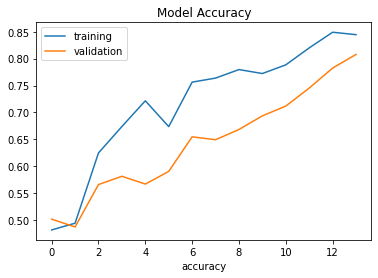

In [9]:
train_values = trial.validation_splits[0].metrics_results['main']['train_values']
validation_values = trial.validation_splits[0].metrics_results['main']['validation_values']

plot_metric(
    train_values=train_values,
    validation_values=validation_values,
    xlabel='epoch',
    ylabel='accuracy',
    title='Model Accuracy'
)

# Visualize Loss

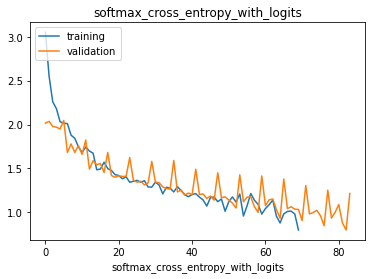

In [10]:
# Get trained pipeline
trained_pipeline = trial.get_trained_pipeline(split_number=0)

train_losses = trained_pipeline.get_step_by_name('TensorflowV1ModelStep').train_losses
validation_losses = trained_pipeline.get_step_by_name('TensorflowV1ModelStep').test_losses

plot_metric(
    train_values=train_losses,
    validation_values=validation_losses,
    xlabel='batch',
    ylabel='softmax_cross_entropy_with_logits',
    title='softmax_cross_entropy_with_logits'
)

# Save pipeline

In [11]:
# Save trained pipeline
trained_pipeline.save(ExecutionContext(DEFAULT_CACHE_FOLDER), full_dump=True)

AttributeError: 'HumanActivityRecognitionPipeline' object has no attribute 'steps_as_tuple'

# Serve Rest Api

In [12]:
pipeline = ExecutionContext(DEFAULT_CACHE_FOLDER).load(HumanActivityRecognitionPipeline.NAME)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

INFO:tensorflow:Restoring parameters from /home/alexandre/Documents/LSTM-Human-Activity-Recognition/cache/HumanActivityRecognitionPipeline/TensorflowV1ModelStep/TensorflowV1ModelStep.ckpt


In [ ]:
app = FlaskRestApiWrapper(
    json_decoder=CustomJSONDecoderFor2DArray(),
    wrapped=pipeline,
    json_encoder=CustomJSONEncoderOfOutputs()
).get_app()

app.run(debug=False, port=5000)

 * Serving Flask app "neuraxle.rest.flask" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
